# Inflation and Escalation using (BLS)
- link PPI codes (for Commodities)
    - Overview: https://www.bls.gov/ppi/overview.htm
    - inudstry: https://download.bls.gov/pub/time.series/pc/pc.industry
    - products: https://download.bls.gov/pub/time.series/pc/pc.product
    - construct code: https://www.bls.gov/help/hlpforma.htm#WP
    - group codes: https://download.bls.gov/pub/time.series/wd/wd.group
    - item codes: https://download.bls.gov/pub/time.series/wd/wd.item


In [ ]:
import pandas as pd
import requests
import json
pd.options.plotting.backend="plotly"

# link PPI codes (for Commodities)
    # Overview: https://www.bls.gov/ppi/overview.htm
    # inudstry: https://download.bls.gov/pub/time.series/pc/pc.industry
    # products: https://download.bls.gov/pub/time.series/pc/pc.product
    # construct code: https://www.bls.gov/help/hlpforma.htm#WP
    # group codes: https://download.bls.gov/pub/time.series/wd/wd.group
    # item codes: https://download.bls.gov/pub/time.series/wd/wd.item
key = 'f735c845833c4374b10b252cecc0d1da'
cpi  = "APU000070111"
bls_ids_commodity = ["WPU14","WPU142","WPU141","WPU14210206","WPU142104" ]
bls_ids = ["PCU336---336---","PCU3364--3364--","PCU3366--3366--", "PCU336611336611", "PCU331---331---" ]
def bls_formatted_data(seriesid=bls_ids,startyear=2011, endyear=2014, key=key):
    data = bls_search(seriesid, startyear,endyear)
    if data['status'] =="REQUEST_SUCCEEDED":
        return bls_format(data)
    else:
        return data


def bls_surveys():
    p = requests.post('https://api.bls.gov/publicAPI/v2/surveys')#, data=data, headers=headers)#,annualaverage=True, registrationkey=key)
    json_data = json.loads(p.text)
    #df = pd.DataFrame(json_data)
    df = pd.DataFrame()    
    for survey in json_data['Results']['survey']:
        tmp = {key: [item] for key, item in survey.items()}
        df= df.append(pd.DataFrame(tmp), ignore_index=True)
    
    return df
def bls_search(seriesid=bls_ids,startyear=2001, endyear=2021, key=key):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": seriesid,"startyear":str(startyear), "endyear":str(endyear), "catalog":True,"annualaverage":True, "registrationkey":key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)#,annualaverage=True, registrationkey=key)
    json_data = json.loads(p.text)
    return json_data
def bls_format(data):
    json_data = data
    df = pd.DataFrame()
    for series in json_data['Results']['series']:
        meta = {key: item for key,item in series['catalog'].items()}
        x=pd.DataFrame(series['data']).assign(**meta)
        df = df.append(x)
    return df
def get_bls(seriesid=bls_ids,startyear=1980, endyear=2022, key=key, annual=True, BY = 2020):
    if endyear -startyear >15:
        print("can only get 15 years at a time, attemptig to glue queries together")
        i = 0
        tmp = pd.DataFrame()
        while startyear + (i * 15) < endyear:
            tmp_data = bls_search(seriesid=seriesid,startyear=startyear +(i*15) , endyear=min(endyear, startyear +(i*15) +15) , key=key)
            tmp = tmp.append(bls_format(tmp_data))
            i=i+1
        #print (tmp.year.unique())
        df = tmp
        
    else:                     
        data= bls_search(seriesid=seriesid,startyear=startyear, endyear=endyear, key=key)
        df = bls_format(data)
    if annual:
        df = df.query('periodName == "Annual"').assign(BY = BY)
        by_vals = df.query(f"year =='{BY}'")[['series_id', 'value']].assign(BY_VALUE = lambda x: x.value).drop('value', axis=1)
        df =df.merge(by_vals, on='series_id', how='left').assign(BY_VALUE = lambda x: x.value.map(float) / x.BY_VALUE.map(float)).reset_index()#.drop_duplicates([['series_id', 'year']])
        
    else:
        df = df.query('periodName != "Annual"')
    return df
    



In [ ]:
data = bls_search()
data
vals = bls_format(data).query('periodName =="Annual"')
vals

bls = get_bls(annual=True, BY=2020)
print("BaseYear =", bls.query("value =='100'").year.unique())
bls.pivot_table(values = 'BY_VALUE', index=['measure_data_type', "BY"], columns=['year'])
#vals.apply(lambda x: x / vals['2020'], axis=1) 

can only get 15 years at a time, attemptig to glue queries together
BaseYear = []


,year,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
measure_data_type,BY,,,,,,,,,,,,,,,,,,,,,
Aerospace product and parts manufacturing,2020,NaN,0.423394,0.423394,0.434514,0.461697,0.484761,0.503707,0.521417,0.535832,0.551895,...,0.888386,0.902389,0.916392,0.924217,0.938633,0.948929,0.966227,0.985173,1.0,1.014518
Primary metal mfg,2020,0.509482,0.497181,0.517683,0.579190,0.608919,0.597130,0.579703,0.572527,0.570989,0.599692,...,1.064070,1.018452,1.030241,0.943106,0.898001,0.981035,1.084059,1.059457,1.0,1.497437
Ship and boat building,2020,NaN,0.445707,0.456650,0.467172,0.488215,0.505471,0.516414,0.529040,0.546717,0.559764,...,0.881734,0.891835,0.909512,0.927609,0.936027,0.946970,0.963384,0.983165,1.0,1.029491
Ship building and repairing,2020,NaN,0.471910,0.483614,0.493914,0.515918,0.533708,0.544007,0.553839,0.577247,0.593633,...,0.919476,0.920880,0.937266,0.954588,0.956929,0.961610,0.971910,0.987360,1.0,1.022168
Transportation equipment manufacturing,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.916201,0.925778,0.938547,0.952115,0.959298,0.970471,0.984038,0.994413,1.0,1.027199


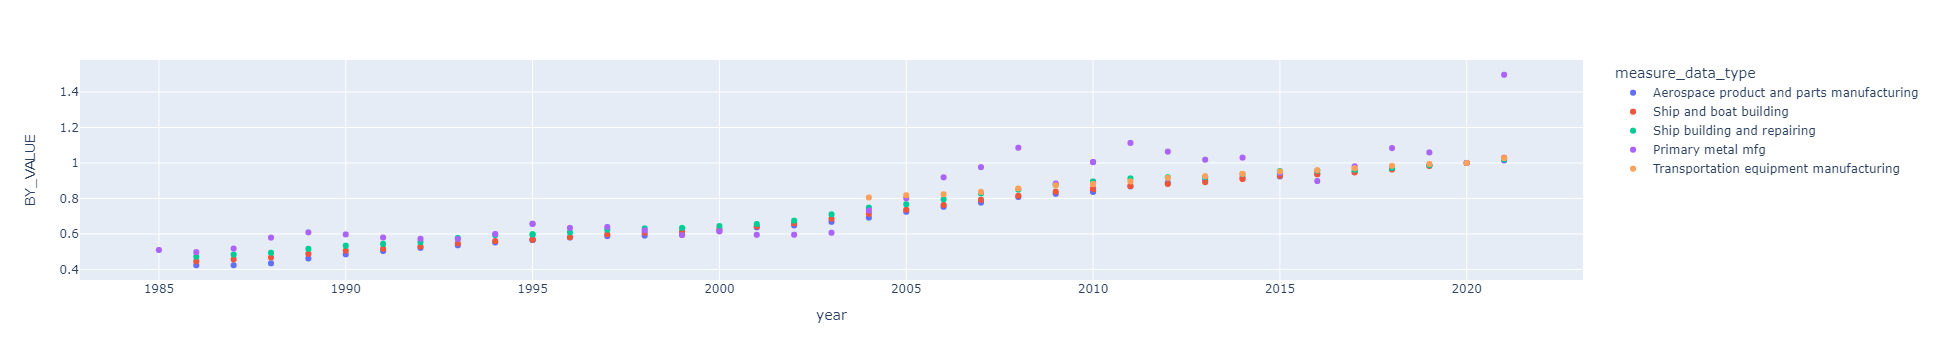

In [ ]:
fig = bls.assign(year=lambda x: x.year.map(int), value = lambda x: x.value.map(float)).plot(x='year', y ='BY_VALUE', color ='measure_data_type', kind='scatter')
fig.show()

In [ ]:
surveys = bls_surveys()
surveys.loc[surveys.survey_name.str.contains("Consumer")]

,survey_abbreviation,survey_name
0,AP,Consumer Price Index - Average Price Data
12,CU,Consumer Price Index - All Urban Consumers
13,CW,Consumer Price Index - Urban Wage Earners and ...
14,CX,Consumer Expenditure Survey
38,LI,Consumer Price Index - Department Store Invent...
43,MU,Consumer Price Index - All Urban Consumers (Ol...
44,MW,Consumer Price Index - Urban Wage Earners and ...
60,SU,Consumer Price Index - Chained Consumer Price ...


In [ ]:
surveys.query("survey_abbreviation in ('PC','WP', 'AP')")

,survey_abbreviation,survey_name
0,AP,Consumer Price Index - Average Price Data
51,PC,Producer Price Index Industry Data
64,WP,Producer Price Index-Commodities
